We want to make sure that our own training pipeline works correctly and does not contain any semantic errors. To do this, we compare our training 
result with a minimal reference implementation in PyTorch Lightning under the same conditions.

## Approach 
# Setup
- Modell: ResNet18 with 1 Input Channel and 2 Output Classes
- Dataset: MGS_Dataset with approx. 2900 images and 2 Classes
- Trainingkonfiguration:
    - Batch Size: 32
    - Learning Rate: 0.001
    - Optimizer: Adam
    - Loss Function: CrossEntropyLoss
    - Epochs: 10
- Datasplit: was identical for both pipelines
- Random Seed: 42 for all experiments


## Own Training Pipeline

In [ ]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from datamodule.dataset import ImageCSVDataset, TransformSubset
from datamodule.transforms import get_train_transforms, get_val_transforms
from utils.model import get_model, get_optimizer
from train_module import ModelTrainer, set_seed

# Reproduzierbarkeit
set_seed(42)

# Dataset laden
dataset = ImageCSVDataset(data_dir=Path("C:/Users/Freun/Desktop/htcv_mgs/data/MGS_data"))

# Transformations
transforms = {
    "train": get_train_transforms(mean=0.36995, std=0.21818),
    "val": get_val_transforms(mean=0.36995, std=0.21818)
}

# Manuelles Splitten
from train_module import RandomSplit
splitter = RandomSplit(val_size=0.2, seed=42)
train_indices, val_indices = splitter.get_splits(dataset)[0]
train_data = TransformSubset(dataset, train_indices, transforms["train"])
val_data = TransformSubset(dataset, val_indices, transforms["val"])

# Trainingskonfiguration
config = {
    "batch_size": 32,
    "optim": "Adam",
    "learning_rate": 0.001,
    "epochs": 10,
    "model_name": "resnet18",
    "pretrained": False,
    "num_classes": 2,
    "lr_scheduler": "none"
}

trainer_cfg = {
    "fold_seeds": [42],
    "shuffle": True,
    "early_stopping": False,
    "patience": None,
    "main_metric": "loss",
    "balancing_strategy": "no_balancing",
    "class_weights": None,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Training starten
trainer = ModelTrainer(model_builder=get_model, optimizer_builder=get_optimizer, **trainer_cfg)
trainer.set_logger(Path("C:/Users/Freun/Desktop/htcv_mgs/results/run/custom_test"))
results = trainer.train(config, train_data, val_data)


## Reference Implementation with PyTorch Lightning

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch

class LitResNet(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(512, 2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# DataLoader mit identischem Split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Lightning Training
pl.seed_everything(42)
model = LitResNet(lr=0.001)
pl_trainer = pl.Trainer(max_epochs=10, logger=TensorBoardLogger("lightning_logs", name="resnet_test"))
pl_trainer.fit(model, train_loader, val_loader)


## Results
We compared the validation loss and accuracy of our training pipeline with the reference implementation. The results are shown in the figures below. 
Looking at the validation loss, we can see that the pytorch lightning pipeline logged in a batch-wise manner, while our own training pipeline logged 
the validation loss at the end of each epoch. Therefore the graphs looks a little different, but the overall trend and the values are very similar, 
except for some minor numerical differences. 

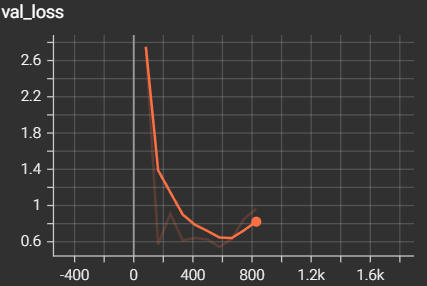
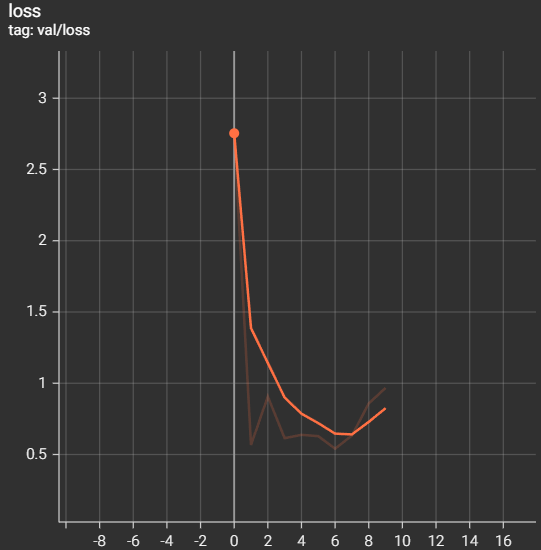

The validation accuracy is also very similar, with only minor numerical differences. The overall trend is the same, and the accuracy values are
very close to each other.

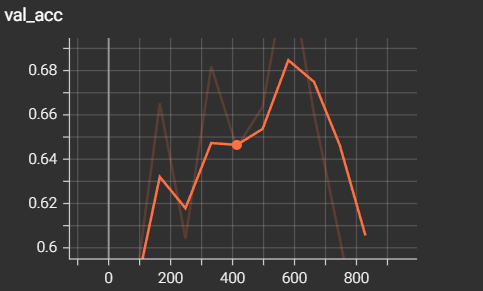
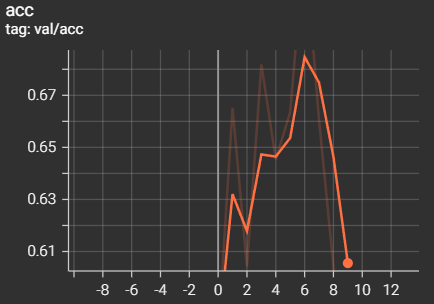

This shows that out own training pipeline works correctly and does not contain any semantic errors. The results are consistent with the reference implementation,
and the minor numerical differences can be attributed to the different logging methods and the inherent randomness in training neural networks.